<a href="https://colab.research.google.com/github/shz9/viprs/blob/master/notebooks/viprs_cli_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Running `viprs` on GWAS summary statistics for Standing Height from the UK Biobank

**Author**: [Shadi Zabad](https://github.com/shz9) (McGill University)

In this notebook, we will provide a concrete example of how to perform polygenic risk score (PRS) inference from GWAS summary statistics using the software `viprs`. In particular, we will showcase how to use the commandline interface to perform inference from genome-wide summary data, covering up to 1.1 million HapMap3 variants.

Before starting, here are some helpful links:

* `viprs` [homepage](https://github.com/shz9/viprs) + [documentation](https://shz9.github.io/viprs/).
* `magenpy` [homepage](https://github.com/shz9/magenpy) + [documentation](https://shz9.github.io/magenpy/).
* [GWAS summary statistics for 9 quantitative phenotypes from the UK Biobank (5-fold cross-validation)](https://zenodo.org/records/14612130)
* [Linkage-Disequilibrium (LD) matrices for six continental ancestry groups from the UK Biobank](https://zenodo.org/records/14614207)
* [VIPRS manuscript](https://pubmed.ncbi.nlm.nih.gov/37030289/)



## Install dependencies

Before we proceed, first we will install the latest version of the `viprs` package (`v0.1.2`) and its associated dependencies (e.g. `magenpy>0.1.4`). To do that, we will use the `pip` package installer:


In [1]:
!pip install -q viprs
!pip show viprs

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 63.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/210.7 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 69.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 62.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 14.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
goog

## The data

Summary statistics-based PRS methods, including `viprs`, require two sources of data to perform inference:

* **GWAS summary statistics**: These are tabular files that record the marginal associations (p-values, betas, etc.) between each genetic variant and the phenotype of interest. The phenotype that we will illustrate here is Standing Height (`HEIGHT`) and the data is provided by the UK Biobank. **Note**:
  * You can download and inspect the summary statistics [here](https://zenodo.org/records/14612130).
  * The GWAS data was generated from European samples ($N=337225$), which were split into 5-folds for the purposes of cross-validation. After splitting the samples, we performed GWAS on each training/testing subset separately and generated corresponding summary statistics. This allows us to evaluate the performance of PRS models without access to individual-level data, using "[pseudo-validation](https://pmc.ncbi.nlm.nih.gov/articles/PMC7612115/#S24)". In this example, we will use training/testing summary statistics for the first split `fold_1`.
    * Given the splitting procedure, training samples come to about ~270,000 individuals whereas testing samples come to about ~67,000 individuals.
  * GWAS summary statistics come in many formats (depending on the software used to perform the association testing), and the `viprs` method supports many popular formats natively. In this example, we used `plink2` to perform association testing, so the summary statistics are in `plink` format.
* **Linkage-Disequilibrium (LD) matrices**: LD matrices record pairwise correlations between genetic variants. These pairwise correlations tend to vary across populations, so you need to make sure that the LD matrix comes from a cohort that is roughly similar in ancestry to the GWAS cohort. **Note:**
  * LD matrices compatible with `viprs` can be downloaded from [here](https://zenodo.org/records/14614207).
  * Since the GWAS data was generated from European samples in the UK Biobank, we will use an LD matrix generated from European samples `EUR.tar.gz`.


The following commands illustrate how to download and extract this data via the commandline (this should take a couple of minutes):

In [2]:
# Create directories for summary statistics and LD data:

!rm -rf /content/sumstats/
!rm -rf /content/ld/
!mkdir -p /content/sumstats/
!mkdir -p /content/ld/EUR/

# Download and extract the height GWAS summary statistics:
!wget -O /content/sumstats/HEIGHT.tar.gz https://zenodo.org/records/14612130/files/HEIGHT.tar.gz?download=1
!tar -xzf /content/sumstats/HEIGHT.tar.gz -C /content/sumstats/
!rm /content/sumstats/HEIGHT.tar.gz

# Download and extract the LD data for European samples:
!wget -O /content/ld/EUR.tar.gz https://zenodo.org/records/14614207/files/EUR.tar.gz?download=1
!tar -xzf /content/ld/EUR.tar.gz -C /content/ld/EUR/
!rm /content/ld/EUR.tar.gz


--2025-01-09 07:54:45--  https://zenodo.org/records/14612130/files/HEIGHT.tar.gz?download=1
Resolving zenodo.org (zenodo.org)... 188.185.45.92, 188.185.43.25, 188.185.48.194, ...
Connecting to zenodo.org (zenodo.org)|188.185.45.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519102714 (495M) [application/octet-stream]
Saving to: ‘/content/sumstats/HEIGHT.tar.gz’

/content/sumstats/H 100%[===================>] 495.05M  8.27MB/s    in 57s     

2025-01-09 07:55:43 (8.74 MB/s) - ‘/content/sumstats/HEIGHT.tar.gz’ saved [519102714/519102714]

--2025-01-09 07:56:00--  https://zenodo.org/records/14614207/files/EUR.tar.gz?download=1
Resolving zenodo.org (zenodo.org)... 188.185.45.92, 188.185.48.194, 188.185.43.25, ...
Connecting to zenodo.org (zenodo.org)|188.185.45.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 309648007 (295M) [application/octet-stream]
Saving to: ‘/content/ld/EUR.tar.gz’

/content/ld/EUR.tar 100%[===================

In [3]:
# Inspect the data:

!echo -e ">>> Check that we have summary statistics for training/testing datasets:"
!ls /content/sumstats/HEIGHT
!echo -e "\n>>> Check that the summary statistics files for all chromosomes are present:"
!ls /content/sumstats/HEIGHT/train/fold_1/
!echo -e "\n>>> Check we have LD matrices for all chromosomes:"
!ls /content/ld/EUR/

>>> Check that we have summary statistics for training/testing datasets:
test  train  validation

>>> Check that the summary statistics files for all chromosomes are present:
chr_10.PHENO1.glm.linear  chr_18.PHENO1.glm.linear  chr_4.PHENO1.glm.linear
chr_11.PHENO1.glm.linear  chr_19.PHENO1.glm.linear  chr_5.PHENO1.glm.linear
chr_12.PHENO1.glm.linear  chr_1.PHENO1.glm.linear   chr_6.PHENO1.glm.linear
chr_13.PHENO1.glm.linear  chr_20.PHENO1.glm.linear  chr_7.PHENO1.glm.linear
chr_14.PHENO1.glm.linear  chr_21.PHENO1.glm.linear  chr_8.PHENO1.glm.linear
chr_15.PHENO1.glm.linear  chr_22.PHENO1.glm.linear  chr_9.PHENO1.glm.linear
chr_16.PHENO1.glm.linear  chr_2.PHENO1.glm.linear
chr_17.PHENO1.glm.linear  chr_3.PHENO1.glm.linear

>>> Check we have LD matrices for all chromosomes:
chr_1	chr_11	chr_13	chr_15	chr_17	chr_19	chr_20	chr_22	chr_4  chr_6  chr_8
chr_10	chr_12	chr_14	chr_16	chr_18	chr_2	chr_21	chr_3	chr_5  chr_7  chr_9


## Fit `viprs` model to GWAS summary statistics data

Here, we will use the commandline interface of the `VIPRS` method to perform Bayesian inference and estimate the joint effect sizes for ~1.1 million HapMap3 variants on height.

The commandline interface for VIPRS can be accessed by simply using the `viprs_fit` command, which requires 4 important arguments:

* `-l` or `--ld-panel` is the path to the LD data. This path can contain a wildcard, like `*` to include data for multiple chromosomes.
* `-s` or `--sumstats` is the path to the summary statistics file(s). This also takes wildcards to accommodates multiple sumstats files.
* `--sumstats-format` is the format of the summary statistics. In this case, we used `plink2` to perform association testing, so we specify the format as `plink`.
* `--output-dir`: The output directory where the joint effect sizes/inference results will be stored.

Putting all of this together gives the following simple command:

In [4]:
!viprs_fit -l "/content/ld/EUR/chr_*" \
           -s "/content/sumstats/HEIGHT/train/fold_1/chr_*" \
           --sumstats-format "plink" \
           --output-dir "/content/model_fit/fold_1/"


        **********************************************
                    _____
            ___   _____(_)________ ________________
            __ | / /__  / ___  __ \__  ___/__  ___/
            __ |/ / _  /  __  /_/ /_  /    _(__  )
            _____/  /_/   _  .___/ /_/     /____/
                          /_/
        Variational Inference of Polygenic Risk Scores
        Version: 0.1.2 | Release date: December 2024
        Author: Shadi Zabad, McGill University
        **********************************************
        < Fit VIPRS models to GWAS summary statistics >
    
---------------------  Parsed arguments  ---------------------

-- ld_dir : /content/ld/EUR/chr_*
-- sumstats_path : /content/sumstats/HEIGHT/train/fold_1/chr_*
-- output_dir : /content/model_fit/fold_1/

-------------  Reading & harmonizing input data  -------------

> Reading the training dataset...
Reading LD metadata: 100% 22/22 [00:00<00:00, 210.12it/s]
Reading summary statistics: 100% 22/22 [00:04<00:00

Here we see that the total runtime is under a minute (as promised 😊). Before we examine the prediction accuracy, let's take a look at some of the outputs of the `VIPRS` software:

In [5]:
!echo -e ">>> The output files:"
!ls /content/model_fit/fold_1/
!echo -e "\n\n>>> The inferred coefficients:"
!zcat /content/model_fit/fold_1/VIPRS_EM.fit.gz | head
!echo -e "\n\n>>> The inferred hyperparameters:"
!head /content/model_fit/fold_1/VIPRS_EM.hyp

>>> The output files:
VIPRS_EM.fit.gz  VIPRS_EM.hyp


>>> The inferred coefficients:
CHR	SNP	POS	A1	A2	BETA	PIP	VAR_BETA
1	rs3131969	754182	G	A	1.5851767e-05	0.005957168	6.393746e-08
1	rs12562034	768448	A	G	5.751042e-06	0.003384103	2.2167043e-08
1	rs4040617	779322	G	A	-1.0923352e-05	0.0047237603	4.2486075e-08
1	rs4970383	838555	A	C	-1.177829e-05	0.0049418714	4.6080107e-08
1	rs4475691	846808	T	C	1.6584332e-06	0.0024371801	1.0095775e-08
1	rs1806509	853954	A	C	5.154455e-07	0.002304032	8.591414e-09
1	rs7537756	854250	G	A	3.944214e-06	0.0029266176	1.6056708e-08
1	rs1110052	873558	T	G	-1.777716e-05	0.0064354097	7.2422765e-08
1	rs7523549	879317	T	C	-1.0675438e-05	0.004659816	4.1472923e-08


>>> The inferred hyperparameters:
Parameter	Value	Chromosome
Residual_variance	0.9639948271214962	1
Heritability	0.03600596293318329	1
Proportion_causal	0.008169818669557571	1
Average_effect_variance	3.8763286624998727e-07	1
Lambda_min	0.0	1
tau_beta	21076.17578125	1
Residual_variance	0.962906502187252	2
H

Here, we see that in its standard form, the `viprs` software outputs two files:

* `VIPRS_EM.fit.gz`: The file contains the inferred effect sizes for all the variants included in the analysis. The columns include standard variant information, such as rsID, position, as well as reference and alternative alleles. It also includes the posterior moments for the effect size, including its posterior mean `BETA`, posterior variance `VAR_BETA`, and posterior includion probability `PIP`.
* `VIPRS_EM.hyp`: This file contains the inferred hyperparameters of the model. The hyperparameters of the model include proportion of causal variants ($\pi$), residual variance ($\sigma_\epsilon^2$), and the pseudo-heritability. Since hyperparameter inference is done on per-chromosome basis, we will have these estimates for each chromosome separately.

## Evaluate `viprs` prediction accuracy using "pseudo R-Squared"

Once the model fitting step is completed, we can go ahead and perform model evaluation. In practical settings, we will have a held-out test dataset with individual-level data where we can do systematic model checking and evaluation. However, this is not possible in this case, as this tutorial will be released to the public.

So, instead, we will perform "[pseudo-validation](https://pmc.ncbi.nlm.nih.gov/articles/PMC7612115/#S24)", where we use summary statistics from an independent dataset to approximate the prediction accuracy on a held-out set. Thankfully, this "test" summary statistics for Standing Height is provided for us from the Zenodo archive discussed earlier (the data was downloaded and can be found under `/content/sumstats/HEIGHT/test/fold_1/`).

How do we compute this "pseudo R-squared"? We will use the evaluation utilities from the `viprs` package to compute this metric.

The following code snippet illustrates how this is done in practice:

In [6]:
# Import the depenedencies:
import magenpy as mgp
import pandas as pd
from viprs.eval.pseudo_metrics import pseudo_r2

# Read the test summary statistics:
test_gdl = mgp.GWADataLoader(ld_store_files="/content/ld/EUR/chr_*",
                             sumstats_files="/content/sumstats/HEIGHT/test/fold_1/chr_*",
                             sumstats_format="plink")

# Read the joint effect sizes inferred by `viprs`:
inferred_betas = pd.read_csv("/content/model_fit/fold_1/VIPRS_EM.fit.gz", sep="\t")

# Compute the pseudo R-squared metric:
print("------- Psuedo-evaluation result -------")
print("\nPseudo-R2:", pseudo_r2(test_gdl, inferred_betas))

Harmonizing data: 100%|██████████| 22/22 [00:09<00:00,  2.42it/s]


------- Psuedo-evaluation result -------

Pseudo-R2: [0.33469194]


Here, we see that the pseudo R-Squared of VIPRS is roughly 33%, which is a good result for height!

## Compute and visualize height polygenic scores in 1000G European samples

Finally, to showcase more general use cases where we actually need to compute these polygenic scores for some downstream analysis, here we demonstrate how to use the inferred effect sizes to estimate polygenic scores for new samples.

In this case, we will use genotype data from European samples ($N=378$) in the 1000G project (CHR22 only).

With utilities provided by `magenpy` and `viprs`, this can be easily done as follows:

> Reading genotype metadata...
> Generating polygenic scores...


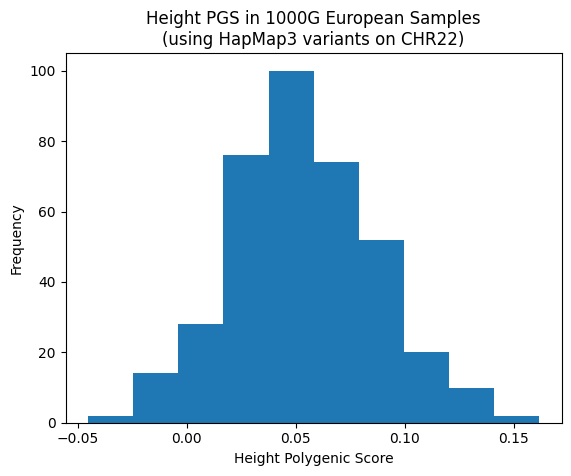

In [7]:
from viprs.model.BayesPRSModel import BayesPRSModel
import matplotlib.pyplot as plt

# Load the genotype data (already attached with magenpy):
gdl = mgp.GWADataLoader(mgp.tgp_eur_data_path())
# Initialize the PRS model:
fitted_model = BayesPRSModel(gdl)
# Read the inferred effect sizes and harmonize them with the genotype data:
fitted_model.read_inferred_parameters("/content/model_fit/fold_1/VIPRS_EM.fit.gz")

# Perform linear scoring (i.e. prediction) on the 1000G samples:
prs = fitted_model.predict()

# Visualize the polygenic score distribution:
plt.hist(prs)
plt.xlabel("Height Polygenic Score")
plt.title("Height PGS in 1000G European Samples\n(using HapMap3 variants on CHR22)")
plt.ylabel("Frequency")
plt.show()

The code above uses the python API to achieve this task. If you have large data, you can also use the commandline script `viprs_score` to compute polygenic scores for new test samples, by providing the following required data:

* `-f` or `--fit-files`: These files are the output of the `viprs_fit` script and contain the effect sizes for each variant from the training sit.
* `--bfile`: The path to the plink1.9 BED files, containing the genotype data for new test samples for whom we wish to compute polygenic scores.
* `--output-file`: The path of the output file containing the computed polygenic scores.

In [8]:
!viprs_score -f "/content/model_fit/fold_1/VIPRS_EM.fit.gz" \
             --bfile {mgp.tgp_eur_data_path()} \
             --output-file "/content/polygenic_scores/HEIGHT_PGS"


        **********************************************
                    _____
            ___   _____(_)________ ________________
            __ | / /__  / ___  __ \__  ___/__  ___/
            __ |/ / _  /  __  /_/ /_  /    _(__  )
            _____/  /_/   _  .___/ /_/     /____/
                          /_/
        Variational Inference of Polygenic Risk Scores
        Version: 0.1.2 | Release date: December 2024
        Author: Shadi Zabad, McGill University
        **********************************************
        < Compute Polygenic Scores for Test Samples >

---------------------  Parsed arguments  ---------------------

-- fit_files : /content/model_fit/fold_1/VIPRS_EM.fit.gz
-- bed_files : /usr/local/lib/python3.10/dist-packages/magenpy/data/1000G_eur_chr22
-- output_file : /content/polygenic_scores/HEIGHT_PGS

--------------------  Reading input data  --------------------

> Reading genotype metadata...

--------------------------------------------------------------

Then by examining the output of the scoring script, we should obtain a file with the computed polygenic scores for all samples:

In [9]:
!head /content/polygenic_scores/HEIGHT_PGS.prs

FID	IID	PRS
HG00096	HG00096	0.06691417543255179
HG00097	HG00097	0.030360036369785275
HG00099	HG00099	0.1066015204373609
HG00100	HG00100	0.007578159069944201
HG00101	HG00101	0.06770485529834258
HG00102	HG00102	0.04497787434307732
HG00103	HG00103	0.03129566008984677
HG00105	HG00105	0.040493636848509304
HG00106	HG00106	0.039545681433869974
